## HW3
### YiTao Hu, Jeff Li,Feiwen Liang, Susu Zhu,Jui-Yu Lan

In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas_market_calendars as mkt_cal

In [3]:
#try to add a time index for the data
nyse = mkt_cal.get_calendar('NYSE')
#we have 6 observations less than the trading days within this time period, so we will start 6 trading days later
trading_days=nyse.valid_days(start_date='1997-01-01', end_date='2002-12-31')[6:]

### Estimation of Cov matrix

ret_act is computed by taking diff(log(tri*isactivenow))

In [4]:
ret_act=pd.read_csv('ret_act.csv')
ret_act.index=trading_days
#fill na returns by 0 to compute the sample cov matrix
ret_act=ret_act.fillna(0)

In [5]:
#function to compute shrinkage coeff
def comptShrinkCov(ret_series):
    S=ret_series.apply(lambda x: np.array(x).reshape(566,1)@np.array(x).reshape(1,566),axis=1).mean()
    shrink_target=np.eye(566)*S.diagonal().mean()
    omega_sq=ret_series.apply(lambda x: ((np.array(x).reshape(566,1)@np.array(x).reshape(1,566)-S)**2).sum(),axis=1).sum()/(252*251)
    Cross_sec_var=((S-shrink_target)**2).sum()
    beta_hat=1-omega_sq/Cross_sec_var
    if beta_hat<0:
        beta_hat=0
    Shrinked_Cov=(1-beta_hat)*shrink_target+beta_hat*S
    return beta_hat,Shrinked_Cov

In [6]:
#estimate the shrinkage parameter monthly or every 21 trading days, with one year or 252 trading days return data
n_periods=ret_act.shape[0]
estimation_periods=252
wins=[(start,start+estimation_periods) for start in range(0,n_periods-estimation_periods,21)]
beta_hats=[comptShrinkCov(ret_act.iloc[win[0]:win[1]])[0] for win in wins]
Shirnk_Cov=np.array([comptShrinkCov(ret_act.iloc[win[0]:win[1]])[1] for win in wins])

In [7]:
beta_hats=pd.DataFrame(beta_hats,index=ret_act.iloc[range(estimation_periods,n_periods,21)].index)

In [8]:
beta_hats.to_csv('./shrink.csv')

 ### signal

#### reversal signal

In [9]:
#set Triangular weights
Tri_weights=np.array([1/11-1/231*j for j in range(21)])[::-1]
Tri_weights=np.repeat(Tri_weights,566).reshape(21,566)

In [10]:
#compute reversal alpha
n_periods=ret_act.shape[0]
estimation_periods=21
wins=[(start,start+estimation_periods) for start in range(0,n_periods-estimation_periods,1)]
alpharev=[-(ret_act.iloc[win[0]:win[1]]*Tri_weights).sum(axis=0) for win in wins]

In [11]:
alpharev=pd.DataFrame(alpharev, index=ret_act.iloc[estimation_periods:].index, columns=ret_act.columns)

In [12]:
def AlphaDecay(signal,estimation_periods,decay_weights):
    n_periods=ret_act.shape[0]
    wins=[(start,start+estimation_periods) for start in range(0,n_periods-estimation_periods,1)]
    alpha=[(signal.iloc[win[0]:win[1]]*decay_weights).sum(axis=0) for win in wins]
    alpha=pd.DataFrame(alpha, index=signal.iloc[estimation_periods:].index, columns=signal.columns)
    return alpha

In [13]:
def signal_standardize(alpha,Winsorize=True):
    alpha=alpha.apply(lambda x: (x-alpha.mean(axis=1))/alpha.std(axis=1),axis=0)
    if Winsorize:
        alpha[alpha<-3]=-3
        alpha[alpha>3]=3
    return alpha

In [14]:
#normalize the alpha
alpharev=signal_standardize(alpharev)

In [15]:
alpharev.to_csv('./alpharev.csv')

#### SHORT-TERM PROCYCLICAL signal

In [16]:
rec=pd.read_csv('rec.csv')
rec=rec[1:]
rec.index=trading_days

In [17]:
#create triangular weights
Tri_weights=np.array([1/23-1/1035*j for j in range(45)])[::-1]
Tri_weights=np.repeat(Tri_weights,566).reshape(45,566)

In [18]:
alpharec=AlphaDecay(rec,45,Tri_weights)
alpharec=signal_standardize(alpharec)
alpharec.to_csv('./alpharec.csv')

#### LONG-TERM CONTRARIAN signal

In [19]:
mtbv=pd.read_csv('mtbv.csv')
mtbv=mtbv[1:]
mtbv.index=trading_days

In [20]:
alphaval=signal_standardize(mtbv)
#for stocks with no btm ratio, we set its alphaval to 0, so we do not take any position 
alphaval=alphaval.fillna(0)
alphaval.to_csv('./alphaval.csv')

#### LONG-TERM CONTRARIAN signal

In [21]:
##setting decay weights: the most recent month would be zero,equal weights other 11 months
Decay_weights=np.ones(252)/(252-21)
Decay_weights[252-21:]=0
Decay_weights=np.repeat(Decay_weights,566).reshape(252,566)

In [22]:
alphamom=AlphaDecay(ret_act,252,Decay_weights)

In [23]:
alphamom=signal_standardize(alphamom)

In [24]:
alphamom.to_csv('./alphamom.csv')

#### Blend the alphas

In [25]:
alphablend=alpharev.reindex_like(alphamom)*0.5+alpharec.reindex_like(alphamom)*0.25+alphaval.reindex_like(alphamom)*0.15+alphamom*0.10
alphablend=signal_standardize(alphablend)
alphablend.to_csv('./alphablend.csv')

### Optimizer

In [26]:
#import tcost
tcost=pd.read_csv('tcost.csv')
tcost=tcost[1:]
tcost.index=trading_days
#shift the t cost for estimating purpose
tcost=tcost.shift(1)

In [27]:
#fill na t costs by the cross-sectional mean
tcost=tcost.reindex_like(alphamom).apply(lambda x: x.fillna(x.mean()) , axis=1)

In [28]:
#flatten the Cov mat
Shirnk_Cov=pd.DataFrame(Shirnk_Cov.reshape(60,566*566),index=beta_hats.index)
#make the freq to daily
Shirnk_Cov=Shirnk_Cov.reindex(alphamom.index).fillna(method='ffill')

##### create a cap weights mkt return to compute mkt beta for each stock

In [29]:
#create a cap weights mkt return 
cap=pd.read_csv('cap.csv')
cap.index=nyse.valid_days(start_date='1997-01-01', end_date='2002-12-31')[5:]

In [30]:
#we fill na by 0, because at that time the stock is not tradable
cap=cap.shift(1).fillna(0)[1:]
#turn cap into cap weights
cap=cap.apply(lambda x: x/x.sum(),axis=1)
#compute mkt returns
mkt_rt=(cap*ret_act).sum(axis=1)

In [31]:
#build the design matrix 
X=pd.concat([pd.Series(np.repeat(1,len(mkt_rt)),index=mkt_rt.index),mkt_rt],axis=1)

In [32]:
#estimate the betas of each stock with one year estimation period
n_periods=ret_act.shape[0]
estimation_periods=252
wins=[(start,start+estimation_periods) for start in range(0,n_periods-estimation_periods)]
betas=[]
for win in wins:
    beta=np.linalg.inv(X.iloc[win[0]:win[1]].T@X.iloc[win[0]:win[1]])@X.iloc[win[0]:win[1]].T@ret_act.iloc[win[0]:win[1]]
    betas.append(beta.iloc[1].values)
betas=pd.DataFrame(np.array(betas),index=ret_act.iloc[estimation_periods:].index)

#### Industry and Country One-Hot encoding

ind_country are a 566 $\times$ 2 dataframe get from R list allStocks where each row represents a stock and the two column is the industry and industry of the stock

In [33]:
ind_country=pd.read_csv('inds_country.csv')
ind_country=ind_country.fillna('Others')

In [34]:
#Perform one-hot encoding on the industry and country for each stock to create the dummy matrix
dum_inds = pd.get_dummies(ind_country, columns=["inds"]).iloc[:,1:]
dum_country= pd.get_dummies(ind_country, columns=["country"]).iloc[:,1:]

In [35]:
#import trading volume
volume=pd.read_csv('volume.csv')
volume=volume[1:]
volume.index=trading_days
volume=volume.shift(1)
#fill na with 0 because these stocks are not tradable
volume=volume.reindex_like(alphamom).fillna(0)

Build the constraints

Quatratic Solver

In [36]:
from cvxopt import matrix, solvers

solve.qp function in cvxopt has the same framework as quadprog's solve.qp in R. Use cvxopt to keep everything in python

In [37]:
def getTrades(alpha,Cov,w,adv,Tcost,beta,dum_country,dum_inds,lamda=1,mu=1):
    #pass in and adjust inputs args
    alpha=alpha.values
    Cov=Cov.values.reshape(566,566)
    w=w.values
    adv=adv.values
    Tcost=Tcost.values
    beta=beta.values.reshape(566,1)
    dum_country=dum_country.values
    dum_inds=dum_inds.values
    LongBook=50000000
    ind_limit=2.5*LongBook/40
    country_limit=2.5*LongBook/18

    
    #define parameters in quadratic problem
    H=2*mu*np.concatenate((np.concatenate((Cov,-Cov),axis=1),np.concatenate((-Cov,Cov),axis=1)),axis=0)
    g=np.concatenate((2*mu*Cov@w-alpha+lamda*Tcost,-2*mu*Cov@w+alpha+lamda*Tcost))
    long_ind=np.concatenate((dum_inds.T,-dum_inds.T),axis=1)
    short_ind=np.concatenate((-dum_inds.T,dum_inds.T),axis=1)
    long_country=np.concatenate((dum_country.T,-dum_country.T),axis=1)
    short_country=np.concatenate((-dum_country.T,dum_country.T),axis=1)
    A=np.concatenate((long_ind,short_ind,long_country,short_country),axis=0)
    b=np.concatenate((ind_limit-dum_inds.T@w,ind_limit+dum_inds.T@w,country_limit-dum_country.T@w,country_limit+dum_country.T@w))
    C=np.concatenate((beta.T,-beta.T),axis=1)
    d=beta.T@w
    #trade and position size constraint 
    theta=np.minimum(15000000*0.015,150000)
    pi=np.minimum(10*theta,0.025*np.sum(LongBook))
    gammas=np.maximum(w-theta,-pi)
    deltas=np.minimum(w+theta,pi)
    LB=np.zeros(2*566)
    UB=np.concatenate((np.maximum(0,np.minimum(theta,pi-w)),np.maximum(0,np.minimum(theta,pi+w))))
    #impose boundaies on the ineq constraints
    A=np.concatenate((A,-np.eye(566*2,566*2),np.eye(566*2,566*2)),axis=0)
    b=np.concatenate((b,LB,UB),axis=0)
    
    H=matrix(H)
    g=matrix(g)
    A=A.astype(np.double)
    A=matrix(A)
    b=matrix(b)
    C=matrix(C)
    d=matrix(d)
    LB=matrix(LB)
    UB=matrix(UB)
    sol=solvers.qp(H,g,A,b,C,d)
    trades=np.array(sol['x'])
    trades=trades[:566]-trades[566:]
    trades=trades.reshape(566)
    return trades

In [38]:
#we not want the progress info
solvers.options['show_progress']=False

In [39]:
from tqdm import tqdm

In [40]:
#compute the trades over backtest time
w=pd.DataFrame(0,index=alphablend.index,columns=alphablend.columns)
trades_sr=pd.DataFrame(0,index=alphablend.index,columns=alphablend.columns)
T=len(alphablend.index)
for t in tqdm(range(T)):
    try:
        trades_sr.iloc[t]=getTrades(alpha=alphablend.iloc[t],
                                    Cov=Shirnk_Cov.iloc[t],
                                    w=w.iloc[t],
                                    adv=volume.iloc[t],
                                    Tcost=tcost.iloc[t],
                                    beta=betas.iloc[t],
                                   dum_country=dum_country,
                                   dum_inds=dum_inds);
        #update positions
        if t<(T-1):
            w.iloc[t+1]=w.iloc[t]+trades_sr.iloc[t]
    except:
        #we almost do not trade if the optimizer returns error,but change w a little bit to get the gradient
        trades_sr.iloc[t]= trades_sr.iloc[t-1]
        if t<(T-1):
            w.iloc[t+1]=w.iloc[t]+trades_sr.iloc[t]

100%|██████████| 1251/1251 [08:31<00:00,  2.44it/s]


In [47]:
#filter trades by isactivenow, we cannot trade stocks that is not active
isactivenow=pd.read_csv('isactivenow.csv')
isactivenow=isactivenow[1:]
isactivenow.index=trading_days
isactivenow=isactivenow.reindex_like(alphablend)
trades_sr=trades_sr*isactivenow

#### Back Test

In [42]:
back_weight=w+trades_sr
raw_pnl=(back_weight*ret_act.reindex(index=alphablend.index)).sum(axis=1)
TcostinEur=(tcost*trades_sr.abs()).sum(axis=1)
pnl=(raw_pnl-TcostinEur).cumsum()
booksize=back_weight.abs().sum(axis=1)
tradesize=trades_sr.abs().sum(axis=1)

In [43]:
trades_sr.to_csv('./trade.csv')
back_weight.to_csv('./back_weight.csv')
pnl.to_csv('./pnl.csv')
booksize.to_csv('./booksize.csv')
tradesize.to_csv('./tradesize.csv')

#### Performance Summary

In [44]:
#compute sharpe ratio,maxdd,and longest_dd
rtn=pnl.diff()[1:]
sharpe=(rtn.mean()/rtn.std())*np.sqrt(252)

In [45]:
import performanceanalytics.table.table as pat
DrawDoneTb=pat.drawdown_table(rtn, -.03)
MaxDD=DrawDoneTb.Depth[1:].min()
longest_dd=DrawDoneTb.iloc[DrawDoneTb.Length.argmax()].Depth 

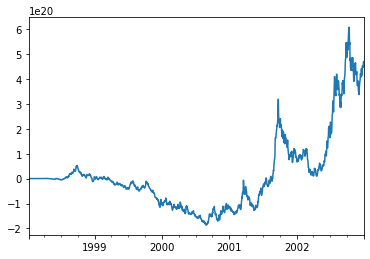

In [49]:
pnl.plot()

In [50]:
sharpe

0.5606514444614201